# Calculating Dollar-Neutral Portfolio #

### Quarterly (63 days) Rebalancing ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.optimize import minimize

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [3]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500
sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [4]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {} 

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df['Adjusted_close']

        df = df.rename("adj_close")
        
        # Fill nans
        df = df.interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [5]:
# Create the Returns DataFrame
returns_dict = {}

# Create the Loop to Obtain the Betas
for ticker in dataframes.keys():
    df = dataframes[ticker].pct_change(1).dropna()
    returns_dict[ticker] = df

# Create the DataFrame
df_returns = pd.DataFrame.from_dict(returns_dict)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [6]:
# Calculate the Correlations Matrix
corr_matrix = df_returns.corr().values  

# Obtain Eigenvalues
eigenvalues, _ = np.linalg.eigh(corr_matrix)

# Identify how much Eigenvalues are small (high colineality)
threshold = 1e-4  # Adjust
num_redundant = sum(eigenvalues < threshold)

print(f"Number of highly colineal variables: {num_redundant}")

Number of highly colineal variables: 0


In [7]:
# Let us Calculate the Weights
def rolling_weights(
    returns,
    desired_returns,
    window=252, 
    rebalance_freq=63
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i-window:i]  # Rolling Window
        
        # Mean and Covariance
        mu = past_returns.mean()
        Sigma = past_returns.cov()

        # Inverse
        lambda_ = 1e-6  # Tikhonov Regularization
        Sigma_inv = np.linalg.inv(Sigma + lambda_ * np.eye(Sigma.shape[0]))
        
        # Sigma_inv = np.linalg.inv(Sigma)

        # Ones
        iota = np.ones(len(mu))

        # Markowitz Components
        A = mu @ Sigma_inv @ mu
        B = mu @ Sigma_inv @ iota
        C = iota @ Sigma_inv @ iota
        D = (A * C) - (B ** 2)

        w = ((desired_returns * C) / D) * (Sigma_inv @ mu) - \
            ((desired_returns * B) / D) * (Sigma_inv @ iota)

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [28]:
# Obtain the Weights

benchmark_mean_returns = sp500.pct_change().mean()
benchmark_mean_returns = benchmark_mean_returns.iloc[0]

dnp_weights = rolling_weights(df_returns, benchmark_mean_returns)

dnp_weights

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.000075,-0.003603,-0.000144,-0.002313,-0.001254,0.002064,-0.014672,0.003337,0.001391,-0.002508,...,-0.005205,-0.015218,0.000331,-0.004866,0.001704,0.001894,-0.001137,0.004403,0.001531,-0.001181
2016-01-06,-0.000075,-0.003603,-0.000144,-0.002313,-0.001254,0.002064,-0.014672,0.003337,0.001391,-0.002508,...,-0.005205,-0.015218,0.000331,-0.004866,0.001704,0.001894,-0.001137,0.004403,0.001531,-0.001181
2016-01-07,-0.000075,-0.003603,-0.000144,-0.002313,-0.001254,0.002064,-0.014672,0.003337,0.001391,-0.002508,...,-0.005205,-0.015218,0.000331,-0.004866,0.001704,0.001894,-0.001137,0.004403,0.001531,-0.001181
2016-01-08,-0.000075,-0.003603,-0.000144,-0.002313,-0.001254,0.002064,-0.014672,0.003337,0.001391,-0.002508,...,-0.005205,-0.015218,0.000331,-0.004866,0.001704,0.001894,-0.001137,0.004403,0.001531,-0.001181
2016-01-11,-0.000075,-0.003603,-0.000144,-0.002313,-0.001254,0.002064,-0.014672,0.003337,0.001391,-0.002508,...,-0.005205,-0.015218,0.000331,-0.004866,0.001704,0.001894,-0.001137,0.004403,0.001531,-0.001181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.002626,0.005797,0.000143,-0.004013,0.000916,0.005686,-0.000981,-0.000742,0.000098,-0.004520,...,-0.001705,0.008447,0.004483,-0.006747,-0.000605,0.008137,-0.004397,-0.002111,0.010347,0.000660
2024-10-23,0.002626,0.005797,0.000143,-0.004013,0.000916,0.005686,-0.000981,-0.000742,0.000098,-0.004520,...,-0.001705,0.008447,0.004483,-0.006747,-0.000605,0.008137,-0.004397,-0.002111,0.010347,0.000660
2024-10-24,0.002626,0.005797,0.000143,-0.004013,0.000916,0.005686,-0.000981,-0.000742,0.000098,-0.004520,...,-0.001705,0.008447,0.004483,-0.006747,-0.000605,0.008137,-0.004397,-0.002111,0.010347,0.000660


In [30]:
# Calculate the DNP

dnp_returns = ((df_returns * dnp_weights).dropna()).sum(axis = 1)
dnp_returns.name = 'ZBP'

dnp_returns

Date
2016-01-05    0.002616
2016-01-06    0.002071
2016-01-07   -0.000562
2016-01-08    0.000490
2016-01-11   -0.000828
                ...   
2024-10-22    0.001940
2024-10-23   -0.000503
2024-10-24   -0.002167
2024-10-25    0.000188
2024-10-28   -0.001152
Name: ZBP, Length: 2219, dtype: float64

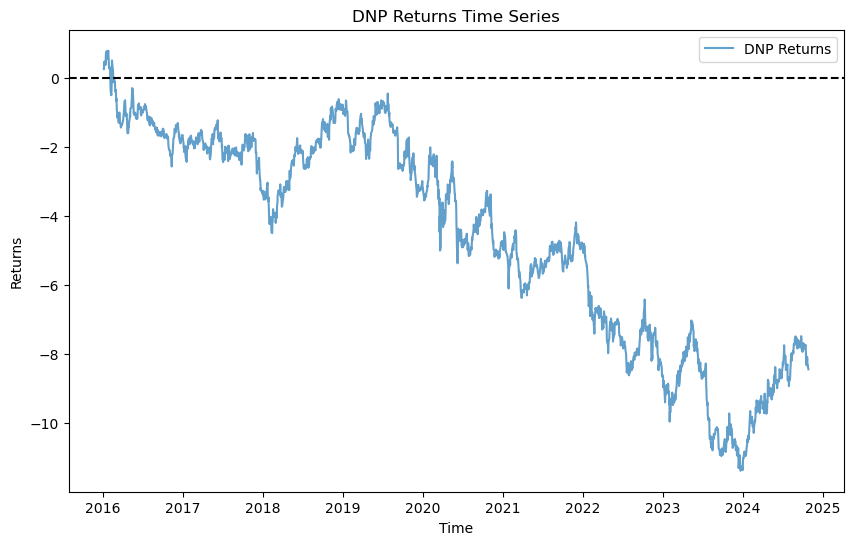

In [32]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(dnp_returns.mul(100).cumsum(), label='DNP Returns', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('DNP Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [33]:
# Calculate the beta
risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)

df_regression = pd.DataFrame()
df_regression['y'] = dnp_returns - risk_free_daily
df_regression['x'] = sp500['sp_500'].pct_change(1) - risk_free_daily
df_regression.dropna(inplace = True)
df_regression = df_regression.mul(100)

df_regression

,y,x
Date,,
2016-01-05,0.255387,0.195042
2016-01-06,0.201140,-1.317530
2016-01-07,-0.062099,-2.375981
2016-01-08,0.043112,-1.089692
2016-01-11,-0.088801,0.079364
...,...,...
2024-10-22,0.182573,-0.058914
2024-10-23,-0.061853,-0.930668
2024-10-24,-0.228196,0.203122


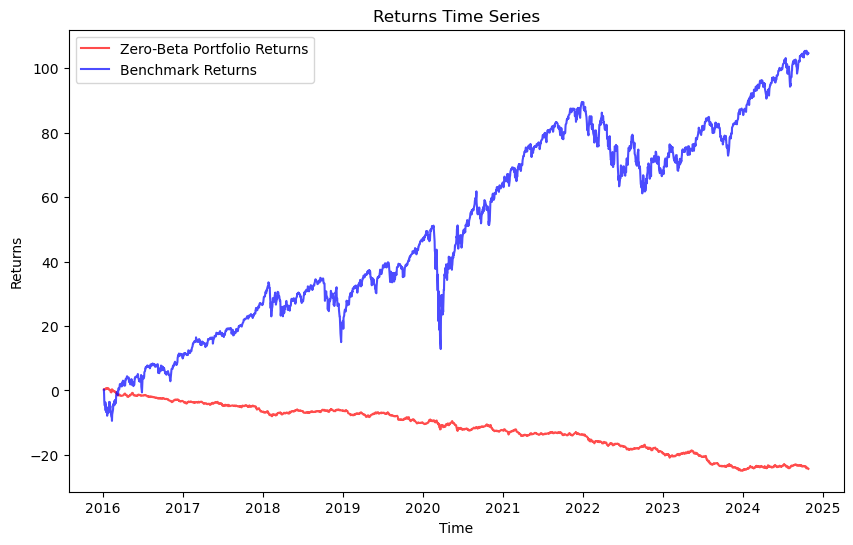

In [36]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(df_regression['y'].cumsum(), label='Zero-Beta Portfolio Returns', color='red', alpha=0.7)
plt.plot(df_regression['x'].cumsum(), label='Benchmark Returns', color='blue', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

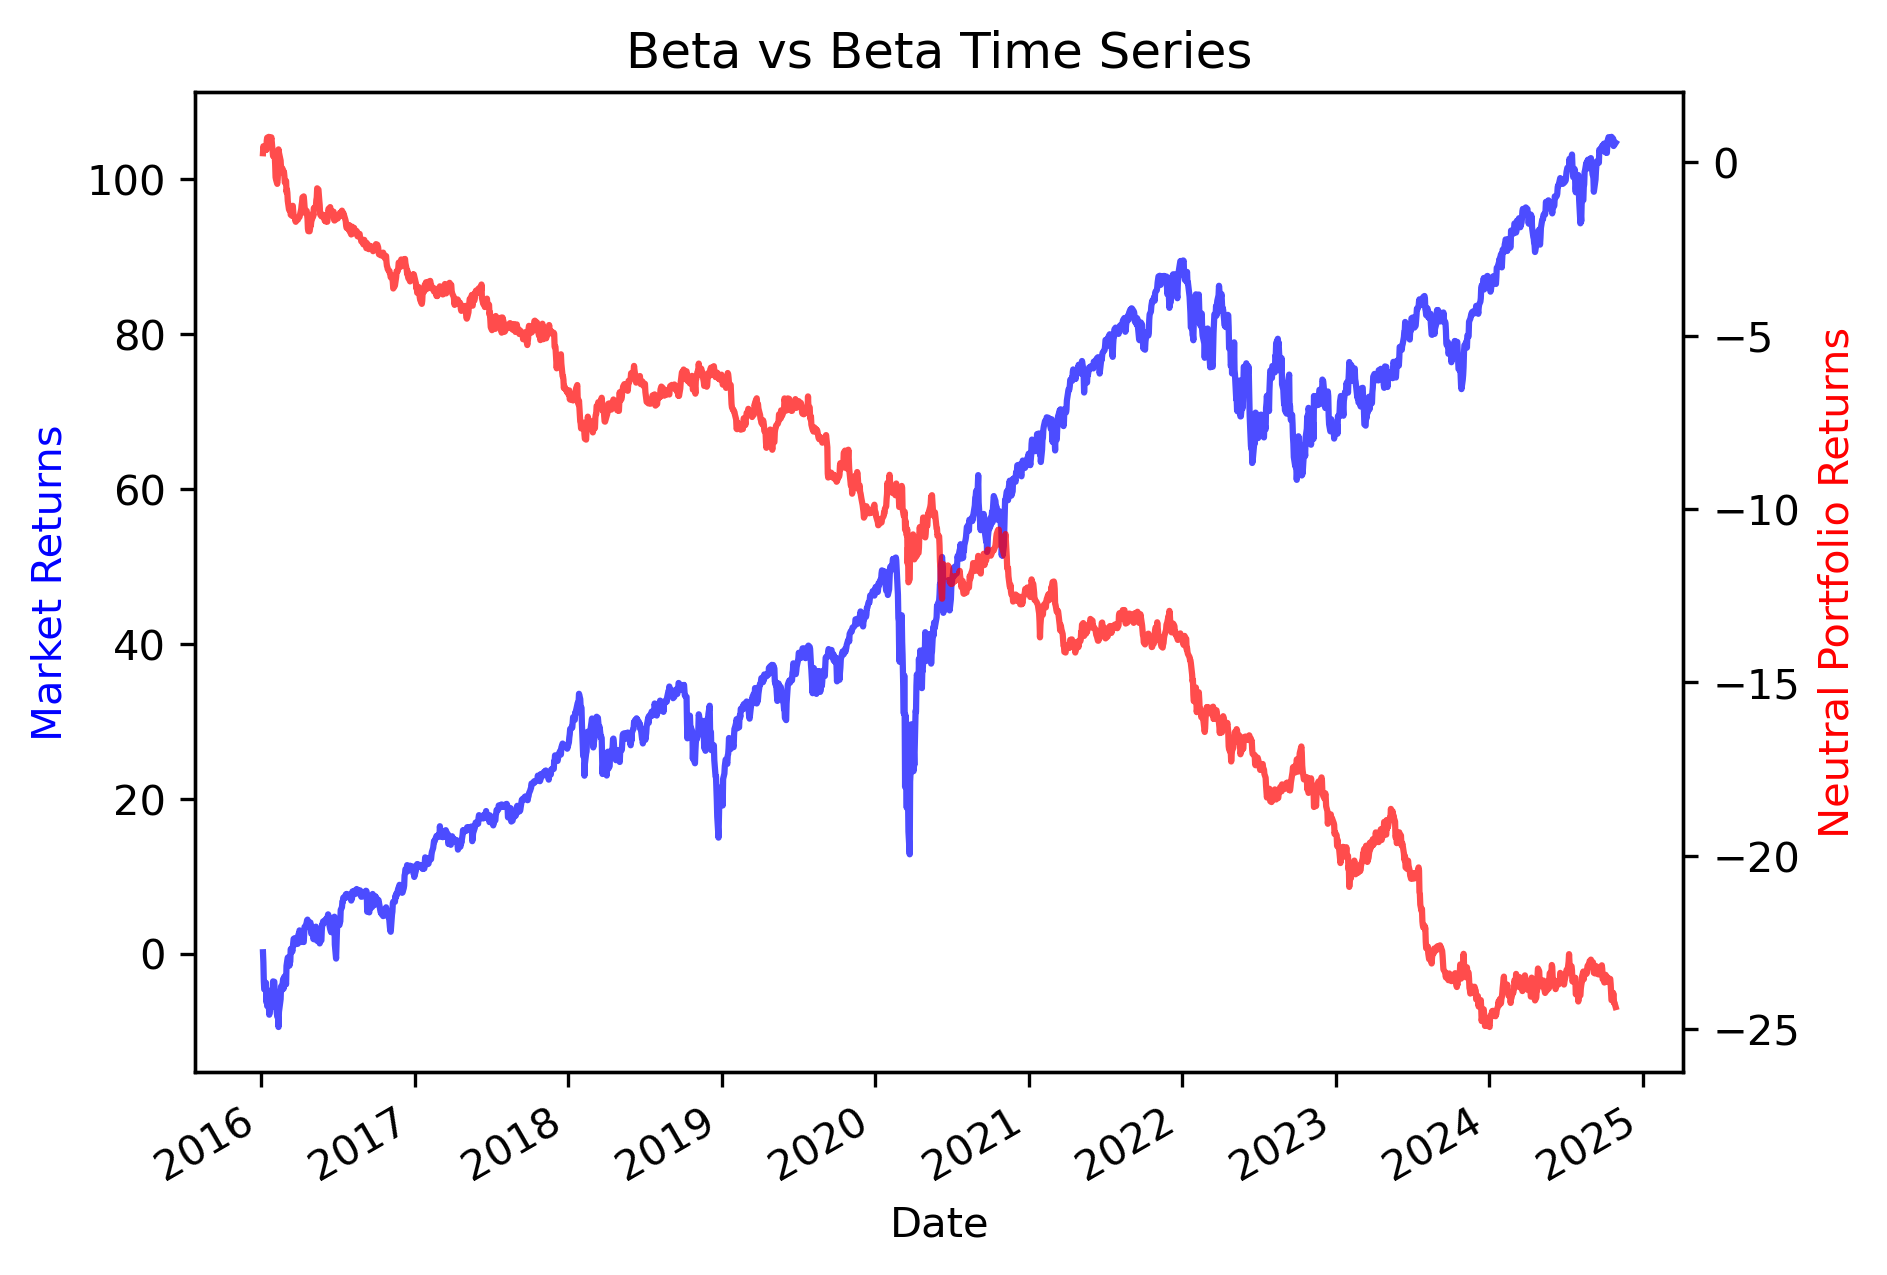

In [38]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
df_regression['x'].cumsum().plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Returns', 
    color='blue'
    )

# ZBP Returns Plot
ax2 = ax1.twinx()

df_regression['y'].cumsum().plot(color = 'red', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Neutral Portfolio Returns', 
    color='red'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

In [39]:
# Correlation between market and our hedge portfolio

df_regression.corr()

,y,x
y,1.000000,0.113368
x,0.113368,1.000000


In [42]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [44]:
#Model specification
window = len(df_regression)
weights = window * wexp(window, window/2)

model = sm.WLS(
    df_regression['y'], 
    sm.add_constant(df_regression['x']),
    missing='drop',
    weights=weights
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary()) 

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     17.74
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.64e-05
Time:                        02:47:20   Log-Likelihood:                 926.23
No. Observations:                2204   AIC:                            -1848.
Df Residuals:                    2202   BIC:                            -1837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0119      0.003     -3.653      0.0

In [46]:
# Set rolling window size
window = 252
weights = window * wexp(window, window/2)

y = df_regression['y']
x = sm.add_constant(df_regression['x'])

# Lists to store rolling coefficients
params = []
index = []
lower_bounds = []
upper_bounds = []

# Rolling regression
for i in range(window, len(df_regression)):
    Y_window = y.iloc[i - window:i]
    X_window = x.iloc[i - window:i]

    # Fit WLS model
    model = sm.WLS(Y_window, X_window, missing='drop', weights=weights).fit()

    # Store coefficients (const, X1, X2)
    params.append(model.params.values)
    index.append(df_regression.index[i])  # Use the last date of the window

    # Store lower and upper bounds of 95% confidence intervals
    ci = model.conf_int(alpha=0.05)  # 95% CI
    lower_bounds.append(ci.iloc[:, 0].values)  # First column: lower bound
    upper_bounds.append(ci.iloc[:, 1].values)  # Second column: upper bound


In [47]:
# Convert list of coefficients to DataFrame
parameters_df = pd.DataFrame(params, columns=x.columns, index=index)
lower_df = pd.DataFrame(lower_bounds, columns=[f'{col}_lower' for col in x.columns], index=index)
upper_df = pd.DataFrame(upper_bounds, columns=[f'{col}_upper' for col in x.columns], index=index)


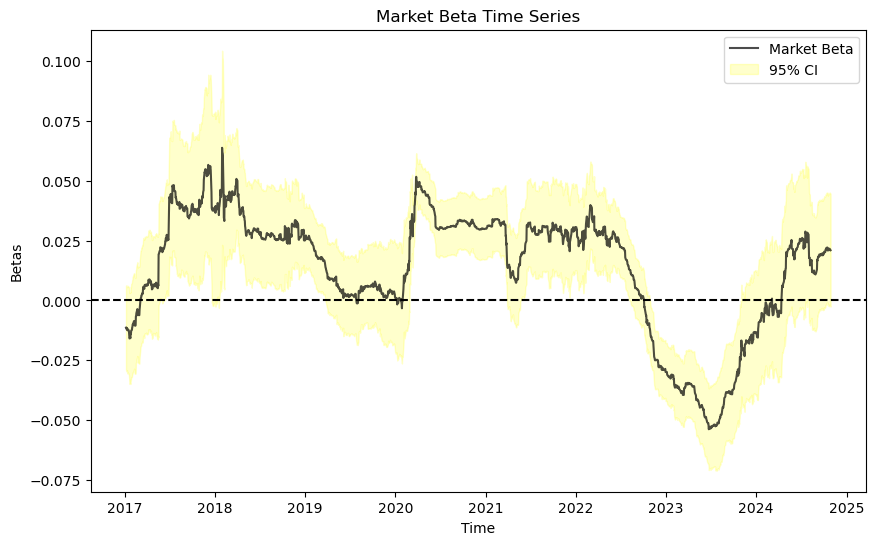

In [48]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(parameters_df['x'], label='Market Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['x_lower'], upper_df['x_upper'], color='yellow', alpha=0.2, label='95% CI')
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Market Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()